# Transfer labels from scRNA-seq using Seurat CCA
**Author**: Adam Klie (last modified: 10/12/2023)<br>
***
**Description**: This script (currently on a single sample)

# Set-up

In [1]:
# Imports
import os
import numpy as np
import scanpy as sc
from muon import atac as ac
import muon as mu
import anndata as ad

import matplotlib.pyplot as plt
import pandas as pd
import anndata2ri
import logging
from scipy.sparse import csr_matrix, issparse, coo_matrix
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
by .GlobalEnv when processing object ‘.pbd_env’


In [ ]:
%%R 
library(Seurat)
library(SeuratObject)
library(Matrix)
library(Signac)
library(EnsDb.Hsapiens.v86)

In [2]:
# Paths
rna_h5ad_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/H1-D39/annotate/publication/annotated.h5ad"
atac_h5ad_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/26Oct23/cellcommander/MM290/threshold_qc/threshold_qc.h5ad"
outdir_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/26Oct23/seurat_label_transfer/MM290"

In [3]:
# Make directory if it doesn't exist
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

In [4]:
# Load in the RNA modality
rna = sc.read_h5ad(rna_h5ad_path)
rna

AnnData object with n_obs × n_vars = 1714 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden', 'initial_leiden_1', 'cellid'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'sctransform_genes'
    uns: 'cellid_colors', 'initial_leiden_1_colors', 'scrublet'
    obsm: 'X_scanpy_default', 'X_scanpy_default_umap', 'X_umap', 'sctransform_scale_data'
    layers: 'counts'

In [5]:
# Load in the ATAC modality
atac = sc.read_h5ad(atac_h5ad_path)
atac

AnnData object with n_obs × n_vars = 3131 × 283866
    obs: 'n_features_by_counts', 'total_counts', 'pct_counts_in_top_20_features', 'log_total_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'outlier', 'atac_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'files'

# RNA data prep

In [36]:
# Prepare data for Seurat
data_mat = rna.X.T.astype("float32")
cell_names = rna.obs_names
gene_names = rna.var_names
metadata = rna.obs

In [37]:
# Load into global environment
ro.globalenv["data_mat"] = data_mat
ro.globalenv["cell_names"] = cell_names
ro.globalenv["gene_names"] = gene_names
ro.globalenv["metadata"] = metadata

In [11]:
%%R
mtx = Matrix(data_mat, sparse = TRUE)
rownames(mtx) = gene_names
colnames(mtx) = cell_names
rna = CreateSeuratObject(counts = mtx, assay = "RNA", meta.data = metadata)
rna <- NormalizeData(rna)
rna <- FindVariableFeatures(rna)
rna <- ScaleData(rna)
rna <- RunPCA(rna)
rna <- RunUMAP(rna, dims = 1:30)

In [23]:
# Create slimmed down adata object for conversion of ATAC modality to Seurat object
data_mat = atac.X.T.astype("float32")
cell_names = atac.obs_names
feature_names = atac.var_names
metadata = atac.obs

In [24]:
# Load into global environment
ro.globalenv["data_mat"] = data_mat
ro.globalenv["cell_names"] = cell_names
ro.globalenv["feature_names"] = feature_names
ro.globalenv["metadata"] = metadata

In [27]:
%%R
mtx = Matrix(data_mat, sparse = TRUE)
rownames(mtx) = feature_names
colnames(mtx) = cell_names
chrom_assay <- CreateChromatinAssay(
  counts = mtx,
  sep = c(":", "-"),
  fragments = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/processed/23Oct23/cellranger/MM290/outs/fragments.tsv.gz",
)
atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "ATAC",
  meta.data = metadata
)

In [29]:
%%R
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevelsStyle(annotations) <- "UCSC"
genome(annotations) <- "hg38"
Annotation(atac) <- annotations

# ATAC data prep

In [30]:
%%R
atac <- RunTFIDF(atac)
atac <- FindTopFeatures(atac, min.cutoff = "q0")
atac <- RunSVD(atac)
atac <- RunUMAP(atac, reduction = "lsi", dims = 2:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_")

In [31]:
%%R
# quantify gene activity
gene.activities <- GeneActivity(atac, features = VariableFeatures(rna))

# add gene activities as a new assay
atac[["activity"]] <- CreateAssayObject(counts = gene.activities)

# normalize gene activities
DefaultAssay(atac) <- "activity"
atac <- NormalizeData(atac)
atac <- ScaleData(atac, features = rownames(atac))

  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=41s  


# Label transfer

In [34]:
%%R
# Identify anchors
transfer.anchors <- FindTransferAnchors(reference = rna, query = atac, features = VariableFeatures(object = rna),
    reference.assay = "RNA", query.assay = "activity", reduction = "cca")

In [40]:
%%R
celltype.predictions <- TransferData(anchorset = transfer.anchors, refdata = rna$cellid,
    weight.reduction = atac[["lsi"]], dims = 2:30)

atac <- AddMetaData(atac, metadata = celltype.predictions)

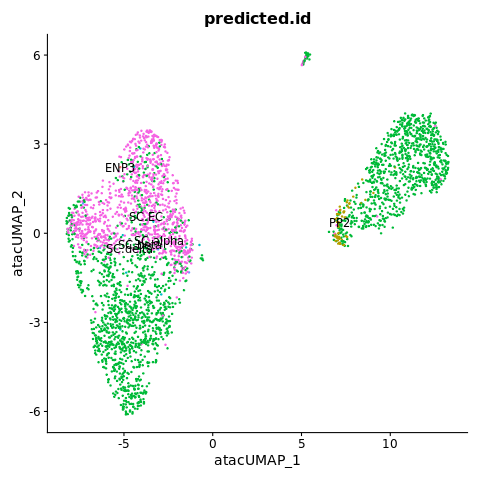

In [44]:
%%R
p1 <- DimPlot(atac, group.by = "predicted.id", label = TRUE) + NoLegend()
p1

# DONE!

---